In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.layers import Layer,Dropout
from keras.layers import LSTM
import warnings
warnings.filterwarnings('ignore')

import datetime
import tensorflow
from statsmodels.tsa.stattools import adfuller,kpss
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras import callbacks
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D,Flatten,Dense,LSTM,Dropout,GRU,Bidirectional
from tensorflow.keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error
from tensorflow.keras.optimizers import legacy


In [2]:
data=pd.read_csv('traffic.csv')
data.head()

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041


In [3]:
data['DateTime']=pd.to_datetime(data['DateTime'])
data.drop('ID',inplace=True,axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   DateTime  48120 non-null  datetime64[ns]
 1   Junction  48120 non-null  int64         
 2   Vehicles  48120 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.1 MB


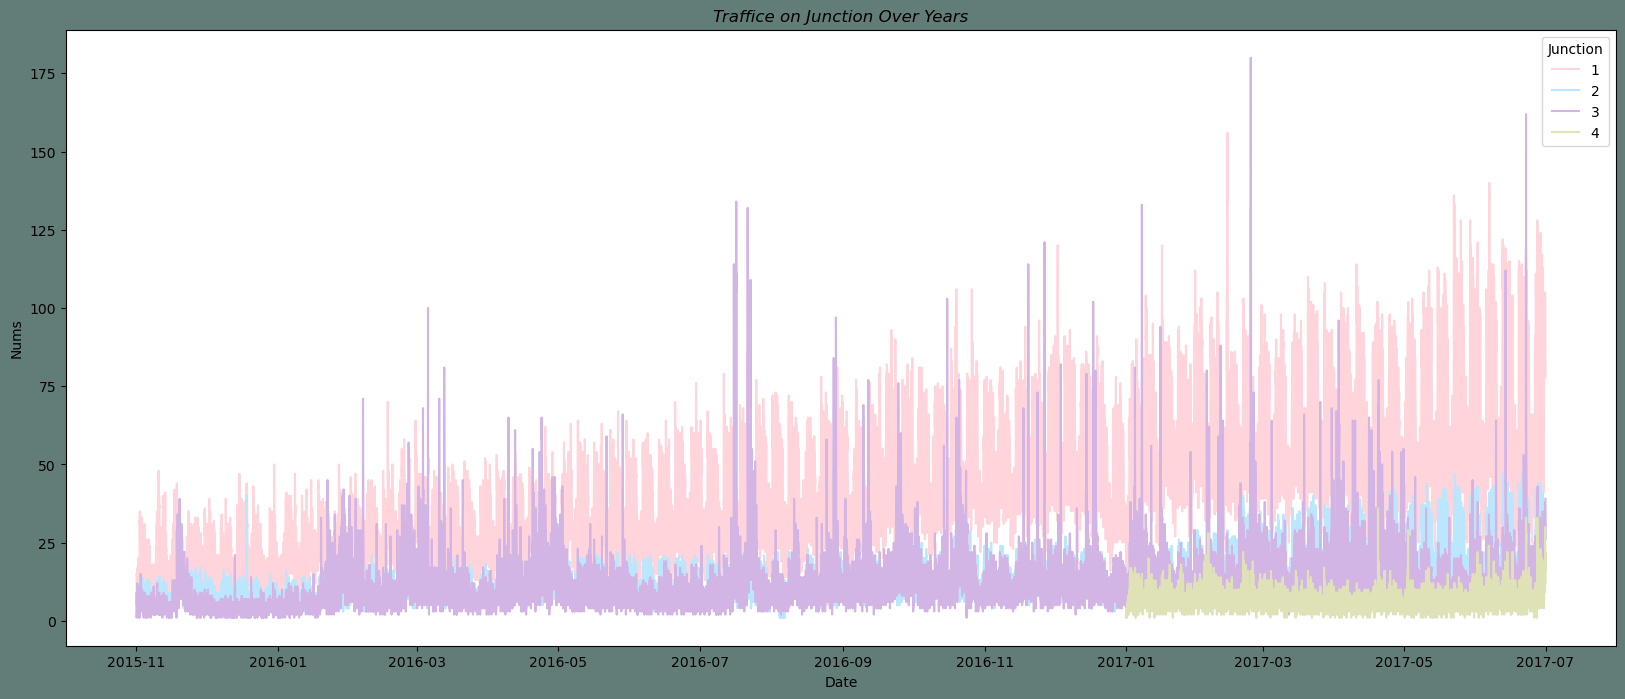

In [4]:
df=data.copy()

colors=['#FFD4DB','#BBE7FE','#D3B5E5','#dfe2b6']
plt.figure(figsize=(20,8),facecolor='#627D78')
Time_series=sns.lineplot(x='DateTime',y='Vehicles',data=df,hue='Junction',palette=colors)
Time_series.set_title('Traffice on Junction Over Years',fontstyle='oblique')
Time_series.set_xlabel('Date')
Time_series.set_ylabel('Nums')
plt.show()

In [5]:
df['Year']=df['DateTime'].dt.year
df['Month']=df['DateTime'].dt.month
df['Date_no']=df['DateTime'].dt.day
df['Hour']=df['DateTime'].dt.hour
df['Day']=df.DateTime.dt.strftime('%A')#返回星期几
df.head()

,DateTime,Junction,Vehicles,Year,Month,Date_no,Hour,Day
0,2015-11-01 00:00:00,1,15,2015,11,1,0,Sunday
1,2015-11-01 01:00:00,1,13,2015,11,1,1,Sunday
2,2015-11-01 02:00:00,1,10,2015,11,1,2,Sunday
3,2015-11-01 03:00:00,1,7,2015,11,1,3,Sunday
4,2015-11-01 04:00:00,1,9,2015,11,1,4,Sunday


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


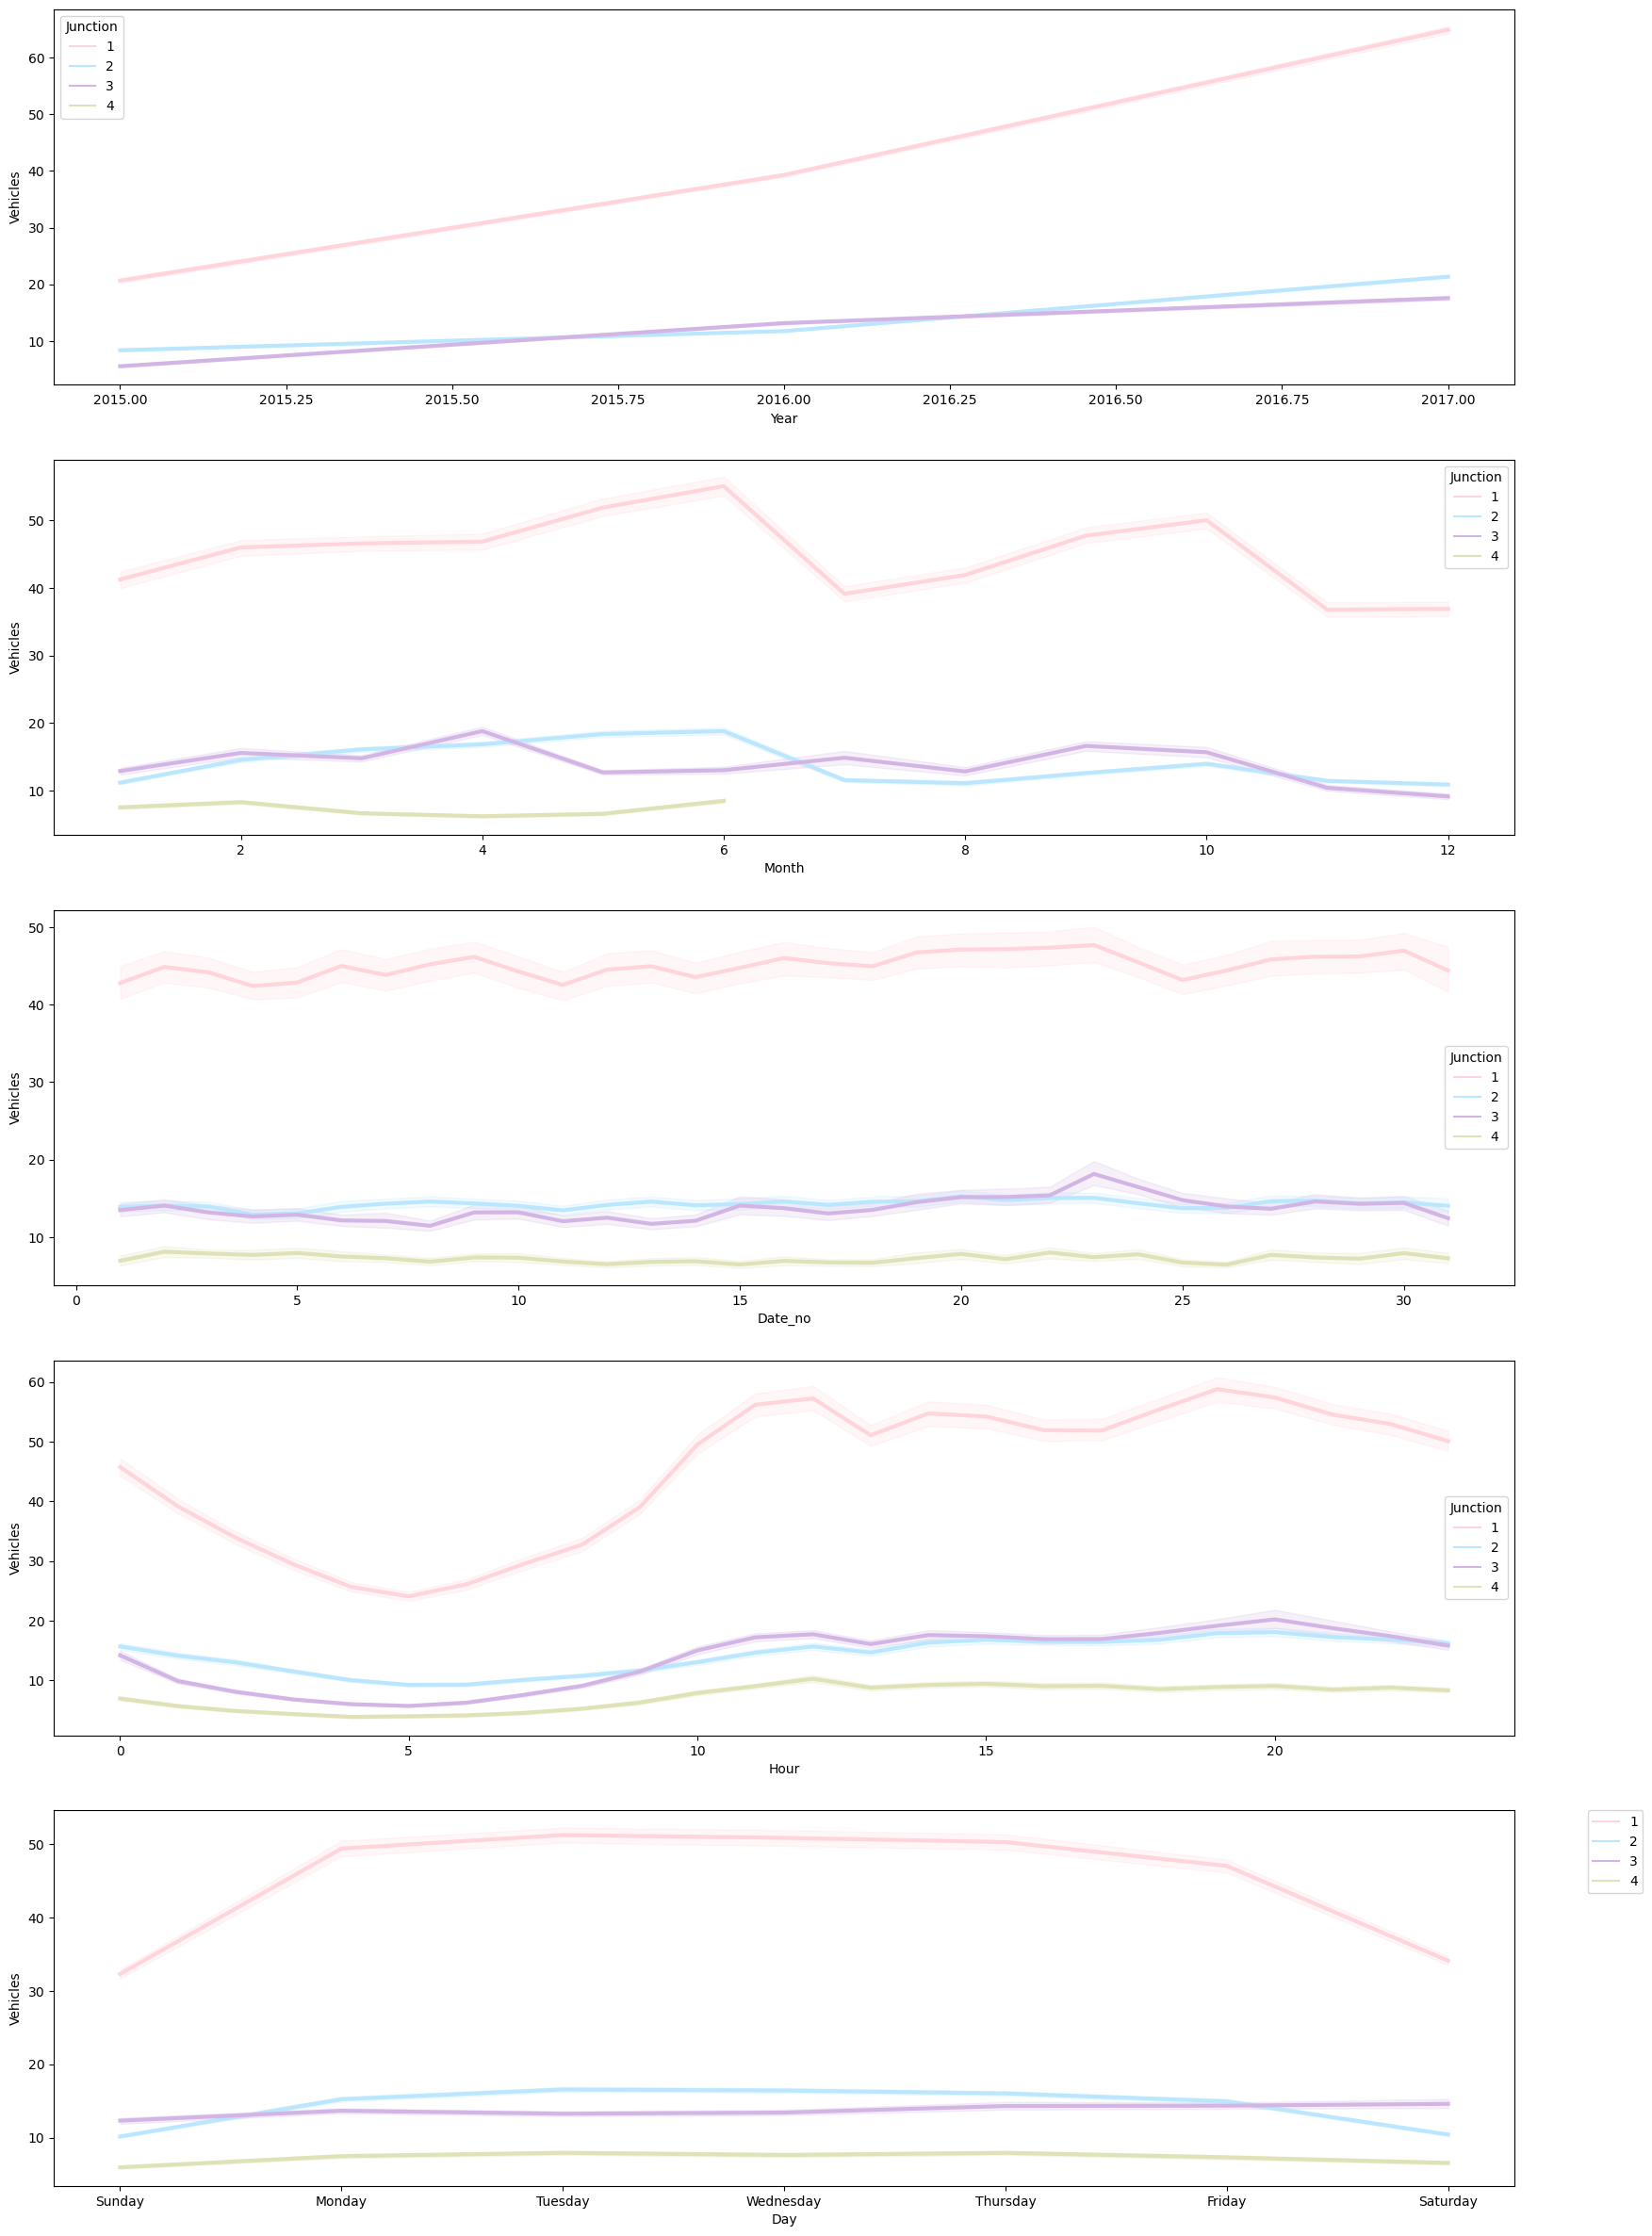

In [6]:
new_features=['Year','Month','Date_no','Hour','Day']

fig,axes=plt.subplots(5,1,figsize=(20,30))
axes=axes.flatten()

for n,i in enumerate(new_features):
    ax=sns.lineplot(x=df[i],y='Vehicles',data=df,hue='Junction',palette=colors,ax=axes[n],linewidth=3)
    plt.legend(bbox_to_anchor=(1.05,1),loc=2,borderaxespad=0.)
    


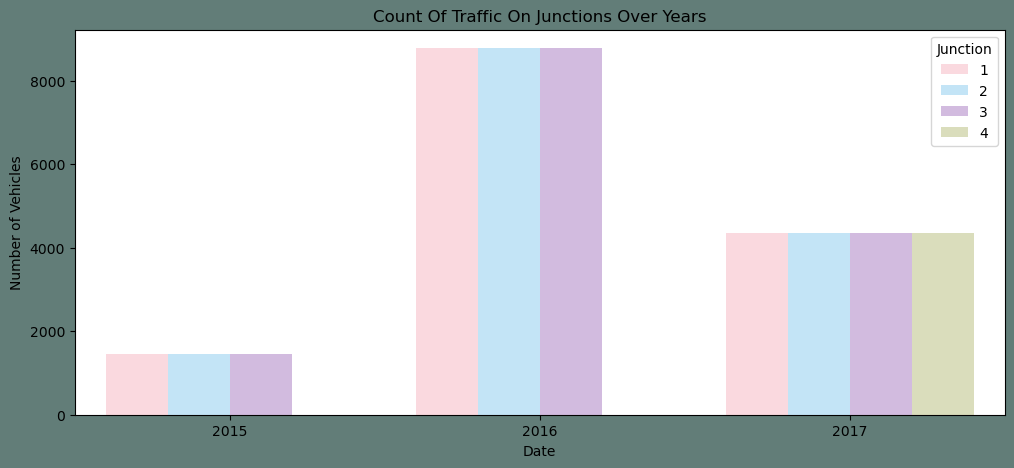

In [7]:
plt.figure(figsize=(12,5),facecolor='#627D78')
count=sns.countplot(data=df,x=df['Year'],hue='Junction',palette=colors)
count.set_title('Count Of Traffic On Junctions Over Years')
count.set_ylabel('Number of Vehicles')
count.set_xlabel('Date')
plt.show()

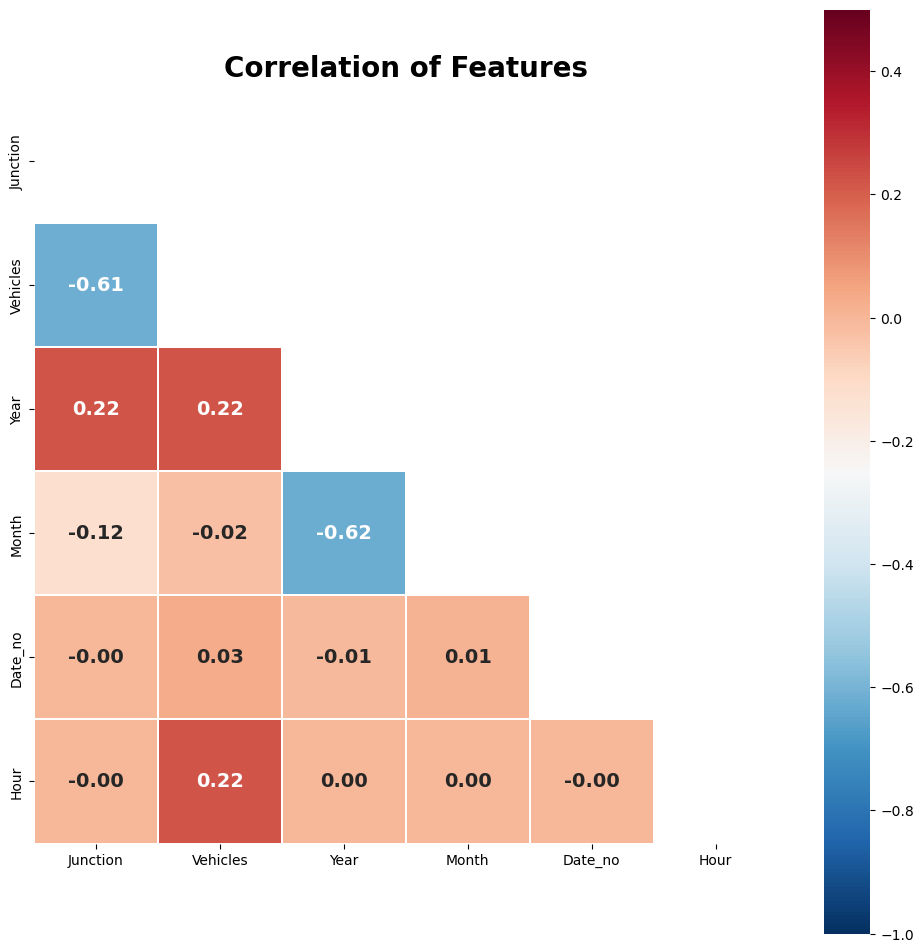

In [8]:
mask=np.zeros_like(df.corr())
mask[np.triu_indices_from(mask)]=True

colormap=plt.cm.RdBu_r
plt.figure(figsize=(12,12))
plt.title('Correlation of Features',fontweight='bold',y=1.02,size=20)
sns.heatmap(df.corr('pearson'),mask=mask,linewidth=0.1,vmax=.5,vmin=-1,square=True,cmap=colormap,linecolor='white',annot=True,annot_kws={'size':14,'weight':'bold'},fmt='.2f')
plt.show()

<Figure size 1500x800 with 0 Axes>

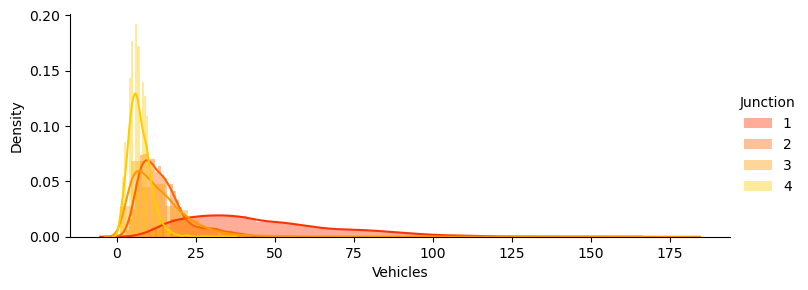

In [9]:
plt.figure(figsize=(15,8))
s=sns.FacetGrid(data,aspect=2.5,palette='autumn',hue='Junction')
s.map(sns.distplot,'Vehicles')
s.add_legend()
plt.show()

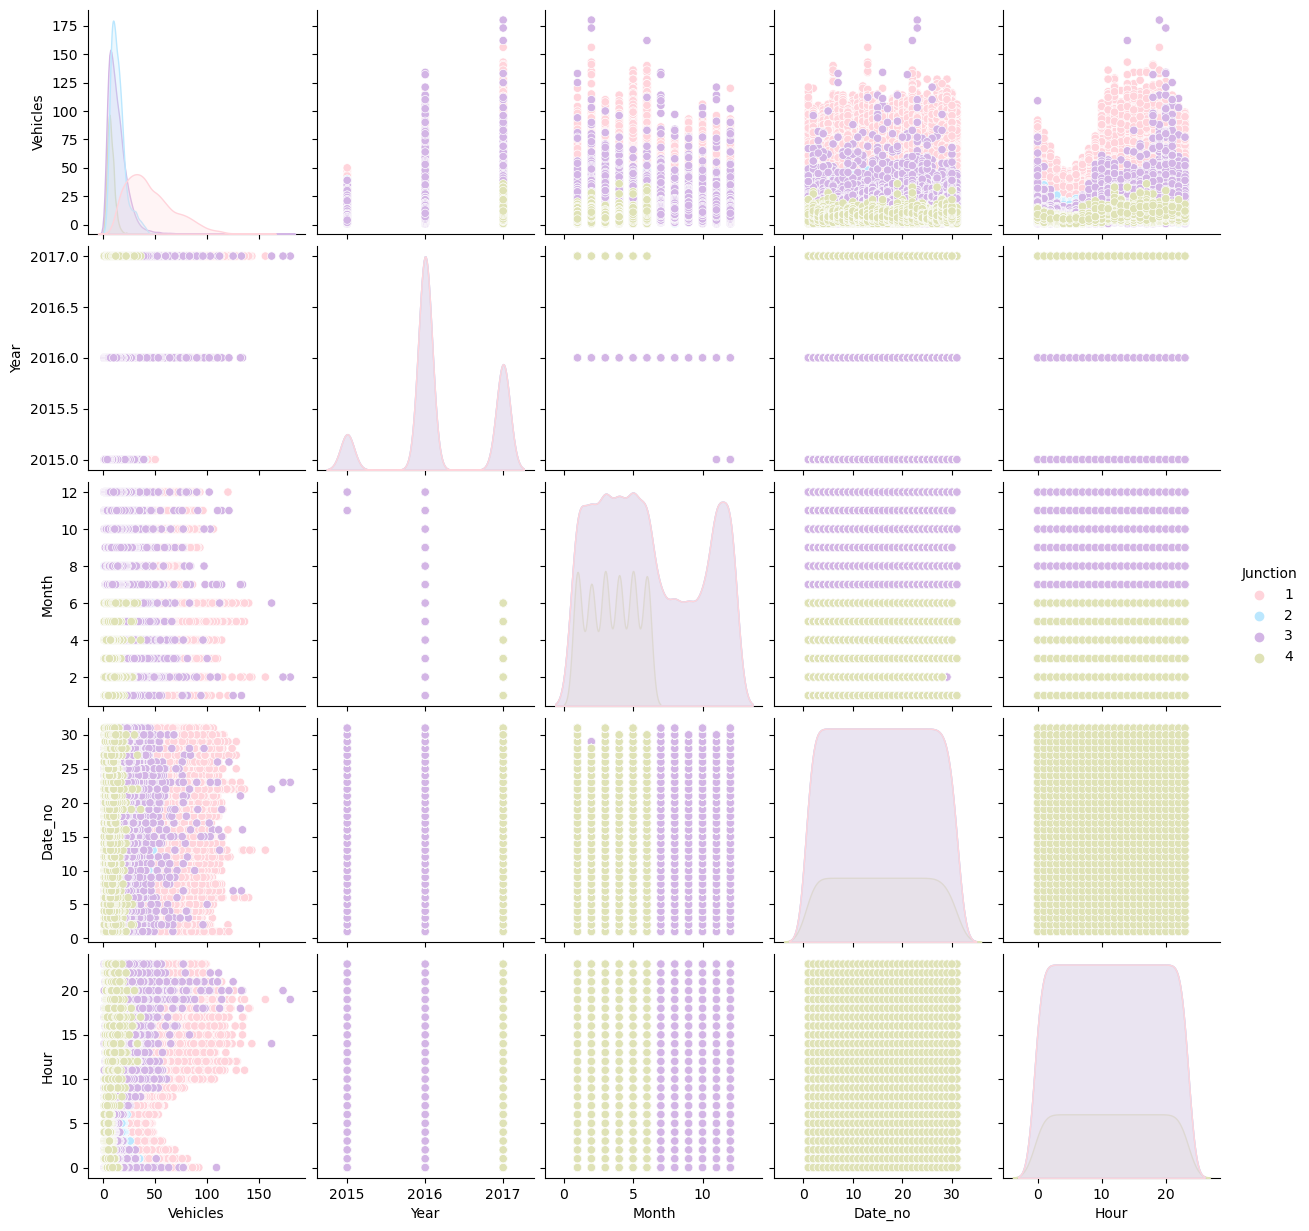

In [10]:
sns.pairplot(df,hue='Junction',palette=colors,diag_kind='kde')

In [11]:
df_j=data.pivot_table(columns='Junction',index='DateTime')
df_j.describe()

Vehicles                                         
Junction             1             2             3            4
count     14592.000000  14592.000000  14592.000000  4344.000000
mean         45.052906     14.253221     13.694010     7.251611
std          23.008345      7.401307     10.436005     3.521455
min           5.000000      1.000000      1.000000     1.000000
25%          27.000000      9.000000      7.000000     5.000000
50%          40.000000     13.000000     11.000000     7.000000
75%          59.000000     17.000000     18.000000     9.000000
max         156.000000     48.000000    180.000000    36.000000

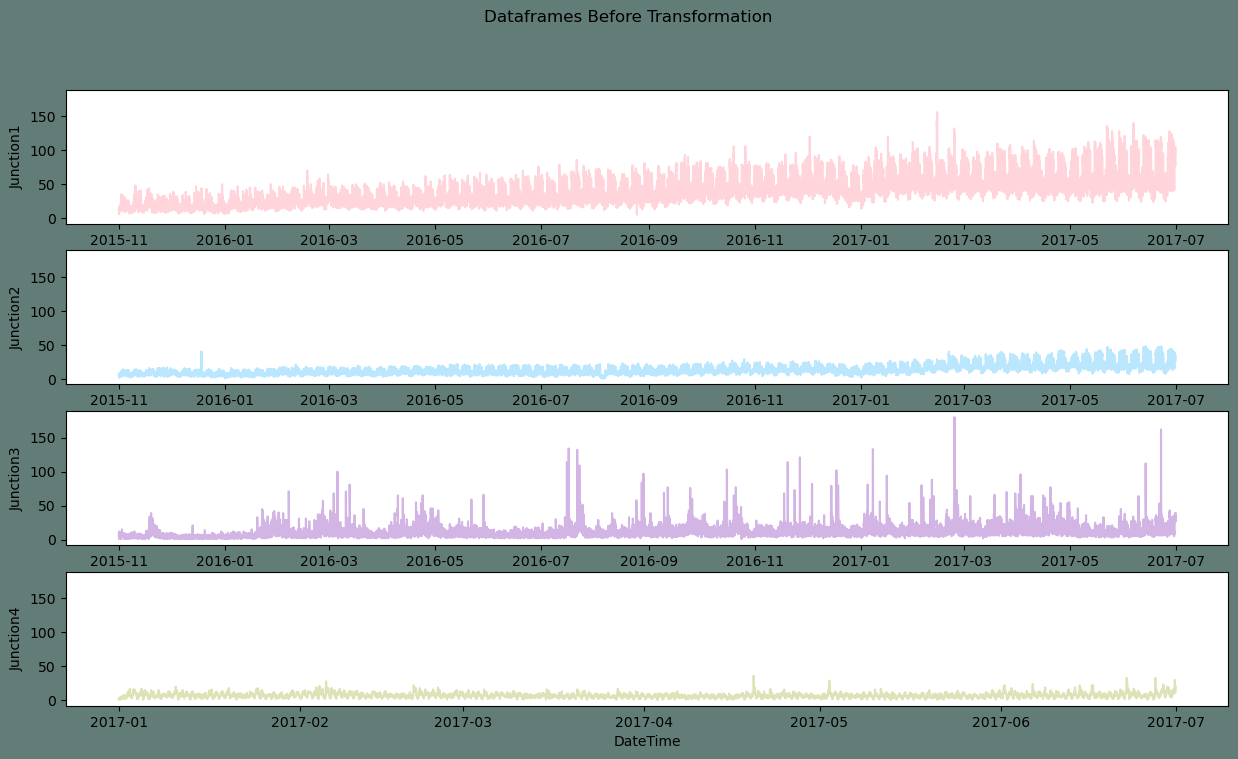

In [12]:
df_1=df_j[[('Vehicles',1)]]
df_2=df_j[[('Vehicles',2)]]
df_3=df_j[[('Vehicles',3)]]
df_4=df_j[[('Vehicles',4)]]

df_4=df_4.dropna()
list_dfs=[df_1,df_2,df_3,df_4]

for i in list_dfs:
    i.columns=i.columns.droplevel(level=1)
    #level=0,去掉外部索引，level=1去掉内部索引
    
    
def Sub_plots(df_1,df_2,df_3,df_4,title):
    fig,axes=plt.subplots(4,1,figsize=(15,8),facecolor='#627D78',sharey=True)
    fig.suptitle(title)
    axes=axes.flatten()
    #J1
    pl_1=sns.lineplot(ax=axes[0],data=df_1,color=colors[0])
    axes[0].set_ylabel('Junction1')
    #J2
    pl_2=sns.lineplot(ax=axes[1],data=df_2,color=colors[1])
    axes[1].set_ylabel('Junction2')
    #J3
    pl_3=sns.lineplot(ax=axes[2],data=df_3,color=colors[2])
    axes[2].set_ylabel('Junction3')
    #J4
    pl_4=sns.lineplot(ax=axes[3],data=df_4,color=colors[3])
    axes[3].set_ylabel('Junction4')
    
Sub_plots(df_1.Vehicles,df_2.Vehicles,df_3.Vehicles,df_4.Vehicles,'Dataframes Before Transformation')


In [13]:
def Adfuller(data):
    check=adfuller(data.dropna())
    print(f'ADF Statictic:{check[0]}')
    print(f'p-value:{check[1]}')
    print(f'Critical Values:')
    for key,value in check[4].items():
        print('\t%s:%.3f'%(key,value))
    if check[0]>check[4]['1%']:
        print('Time Series is Non-Stationary')
    else:
        print('Time Series is Stationary')


def normalization(data,col):
    mean=data[col].mean()
    std=data[col].std()
    data[col]=(data[col]-mean)/std
    return data


In [14]:
df_1=normalization(df_1,'Vehicles')
df_2=normalization(df_2,'Vehicles')
df_3=normalization(df_3,'Vehicles')
df_4=normalization(df_4,'Vehicles')


In [15]:
df_1['Diff']=df_1['Vehicles'].diff(24*7)
df_2['Diff']=df_2['Vehicles'].diff(24*7)
df_3['Diff']=df_3['Vehicles'].diff(24*7)
df_4['Diff']=df_4['Vehicles'].diff(24*7)


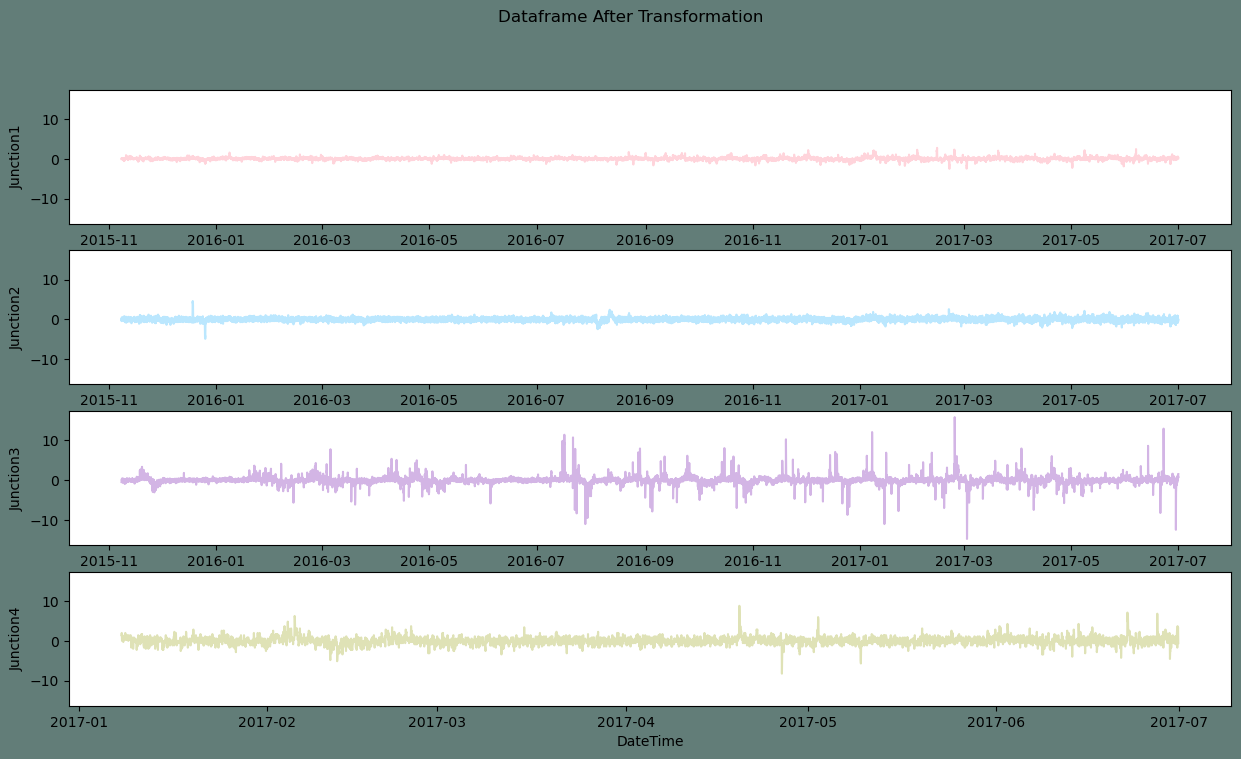

In [16]:
Sub_plots(df_1.Diff,df_2.Diff,df_3.Diff,df_4.Diff,'Dataframe After Transformation')

In [17]:
list_df_nb=[df_1.Diff,df_2.Diff,df_3.Diff,df_4.Diff]

for i in list_df_nb:
    print('\n')
    Adfuller(i)



ADF Statictic:-15.265303390415436
p-value:4.79853987639675e-28
Critical Values:
	1%:-3.431
	5%:-2.862
	10%:-2.567
Time Series is Stationary


ADF Statictic:-13.95255084713779
p-value:4.673584441608371e-26
Critical Values:
	1%:-3.431
	5%:-2.862
	10%:-2.567
Time Series is Stationary


ADF Statictic:-12.207967265201459
p-value:1.1815860483260652e-22
Critical Values:
	1%:-3.431
	5%:-2.862
	10%:-2.567
Time Series is Stationary


ADF Statictic:-8.314247458372613
p-value:3.717612447139096e-13
Critical Values:
	1%:-3.432
	5%:-2.862
	10%:-2.567
Time Series is Stationary


In [18]:
df_j1=df_1.dropna()
df_j2=df_2.dropna()
df_j3=df_3.dropna()
df_j4=df_4.dropna()


In [32]:
def split_data(data):
    lenth_data=len(data)
    size=int(lenth_data*0.9)
    train,test=data[:size],data[size:]
    train,test=train.values.reshape(-1,1),test.values.reshape(-1,1)
    return train,test

In [35]:
J1_train,J1_test=split_data(df_j1)
J2_train,J2_test=split_data(df_j2)
J3_train,J3_test=split_data(df_j3)
J4_train,J4_test=split_data(df_j4)

def get_features(df):
    X=[]
    y=[]
    steps=32
    for i in range(32,len(df)):
        X.append(df[i-steps:i,:])
        y.append(df[i,0])
        
    X,y=np.array(X),np.array(y)
    X,y=X.reshape(X.shape[0],X.shape[1],1),y.reshape(y.shape[0],1)
    return X,y

In [37]:
X_trainJ1,y_trainJ1=get_features(J1_train)
X_testJ1,y_testJ1=get_features(J1_test)

X_trainJ2,y_trainJ2=get_features(J2_train)
X_testJ2,y_testJ2=get_features(J2_test)

X_trainJ3,y_trainJ3=get_features(J3_train)
X_testJ3,y_testJ3=get_features(J3_test)

X_trainJ4,y_trainJ4=get_features(J4_train)
X_testJ4,y_testJ4=get_features(J4_test)


In [38]:
X_trainJ1.shape,y_trainJ1.shape

((25930, 32, 1), (25930, 1))

In [ ]:
def GRU_model(X_train,y_train,X_test):
    early_stopping=callbacks.EarlyStopping(min_delta=0.001,patience=10,restore_best_weights=True)
    
    model=Sequential()
    model.add(GRU(units=150,return_sequences=True,input_shape=(X_train.shape[1],1),activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=150,return_sequences=True,activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=50,return_sequences=True,activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=50,activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    optimizer=legacy.SGD(lr=0.001,decay=0.01)
    model.compile(optimizer=optimizer,loss='mse')
    history=model.fit(X_train,y_train,epochs=50,batch_size=150,callbacks=[early_stopping],validation_split=0.2)
    pred_GRU=model.predict(X_test)
    return history,pred_GRU,model

def rmse_value(test,pred):
    rmse=math.sqrt(mean_squared_error(test,pred))
    print('The root mean squarred error is{}'.format(rmse))
    return rmse




history,pred,model=GRU_model(X_trainJ1,y_trainJ1,X_testJ1)



Epoch 1/50
139/139 [==============================] - 25s 143ms/step - loss: 0.3414 - val_loss: 0.7409
Epoch 2/50
139/139 [==============================] - 19s 137ms/step - loss: 0.3252 - val_loss: 0.7321
Epoch 3/50
139/139 [==============================] - 19s 136ms/step - loss: 0.3182 - val_loss: 0.7217
Epoch 4/50
139/139 [==============================] - 19s 136ms/step - loss: 0.3137 - val_loss: 0.7124
Epoch 5/50
139/139 [==============================] - 19s 136ms/step - loss: 0.3108 - val_loss: 0.7043
Epoch 6/50
139/139 [==============================] - 19s 135ms/step - loss: 0.3079 - val_loss: 0.6973
Epoch 7/50
139/139 [==============================] - 18s 130ms/step - loss: 0.3060 - val_loss: 0.6913
Epoch 8/50
139/139 [==============================] - 19s 134ms/step - loss: 0.3037 - val_loss: 0.6861
Epoch 9/50
118/139 [========================>.....] - ETA: 2s - loss: 0.3013

In [ ]:
def PredictionPlot(test,predicted,m):
    plt.figure(figsize=(12,5))
    plt.plot(test,color=colors[m],label='True Value',alpha=0.5)
    plt.plot(predicted,color='#627D78',label='Predicted Value')
    plt.title('GRU Traffiec Prediction VS True Values')
    plt.xlabel('Datetime')
    plt.ylabel('Number of Vehicles')
    plt.show()
    

In [ ]:
RMSE_J1=rmse_value(y_testJ1,pred)

PredictionPlot(y_testJ1,pred,0)

In [61]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_27 (GRU)                (None, 32, 150)           68850     
                                                                 
 dropout_26 (Dropout)        (None, 32, 150)           0         
                                                                 
 gru_28 (GRU)                (None, 32, 150)           135900    
                                                                 
 dropout_27 (Dropout)        (None, 32, 150)           0         
                                                                 
 gru_29 (GRU)                (None, 32, 50)            30300     
                                                                 
 dropout_28 (Dropout)        (None, 32, 50)            0         
                                                                 
 gru_30 (GRU)                (None, 32, 50)           

In [60]:
pred.shape

(2854, 32, 1)